# Crime Analysis and Safety Prediction Modeling

In this project, we will cluster the crime rate in New York City and use it to predict safety level of the airbnb houses.<br>
Here is the basic idea of how it works.

### Steps of the prediction modeling
1. Data Collection and Preprocessing
2. Clustering NYC using the crime rates
3. Classification modeling to calculate the safety level by coordinates
4. Predict the safety level of AirBnB houses



In [38]:
import numpy as np
import pandas as pd
import sys

import matplotlib.pyplot as plt

In [75]:
# HTML display setting
from IPython.core.display import display, HTML
display(HTML(data="""
<style> div#notebook-container { width: 50%; } div#menubar-container { width: 85%; } div#maintoolbar-container { width: 99%; } </style>
"""))

# Dataframe display setting
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.encoding = sys.stdout.encoding

# Data Collection and Preprocessing

In [117]:
data_crime = pd.read_csv('C:/Users/Nam Sung Hyun/Desktop/CX4242/Project/NYPD_Complaint_Data_Current_YTD.csv')
data_airbnb = pd.read_csv('C:/Users/Nam Sung Hyun/Desktop/CX4242/20180401_Airbnb_Data.csv')

## 1. Crime Data

[Crime Data from NYPD OpenData](https://data.cityofnewyork.us/api/views/5uac-w243/files/5622c761-4377-4060-a628-ee39ad5c5497?download=true&filename=NYPD_Incident_Level_Data_Column_Descriptions.csv) has **24 attributes and 468,761 instances**.<br>
Below is the description of the attributes explained in the [footnote](https://data.cityofnewyork.us/api/views/5uac-w243/files/fc4f191a-6adf-4268-a1ae-8525a8d7027b?download=true&filename=NYPDIncidentLevelDataFootnotes.pdf).

### Data Description

| Field Name | Description |
|:----------:|:-------------|
| CMPLNT_NUM | Randomly generated persistent ID for each complaint |
| CMPLNT_FR_DT | Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists) |
| CMPLNT_FR_TM | Exact time of occurrence for the reported event (or starting time of occurrence, if CMPLNT_TO_TM exists) |
| CMPLNT_TO_DT | Ending date of occurrence for the reported event, if exact time of occurrence is unknown |
| CMPLNT_TO_TM | Ending time of occurrence for the reported event, if exact time of occurrence is unknown |
| RPT_DT | Date event was reported to police |
| KY_CD | Three digit offense classification code |
| OFNS_DESC | Description of offense corresponding with key code |
| PD_CD | Three digit internal classification code (more granular than Key Code) 
| PD_DESC | Description of internal classification corresponding with PD code (more granular than Offense Description) 
| CRM_ATPT_CPTD_CD | Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely 
| LAW_CAT_CD | Level of offense: felony, misdemeanor, violation |
| JURIS_DESC | Jurisdiction responsible for incident. Either internal, like Police, Transit, and Housing; or external, like Correction, Port Authority, etc. 
| BORO_NM | The name of the borough in which the incident occurred 
| ADDR_PCT_CD |The precinct in which the incident occurred 
| LOC_OF_OCCUR_DESC | Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of 
| PREM_TYP_DESC | Specific description of premises; grocery store, residence, street, etc. 
| PARKS_NM | Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included) 
| HADEVELOPT | Name of NYCHA housing development of occurrence, if applicable 
| X_COORD_CD | X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) 
| Y_COORD_CD | Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104) 
| Latitude | Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)  
| Longitude | Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)

### Overview

In [118]:
data_crime.head(5)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,JURIS_DESC,BORO_NM,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,579468609,12/31/2017,23:55:00,NaN,NaN,12/31/2017,118,DANGEROUS WEAPONS,792.0,WEAPONS POSSESSION 1 & 2,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,67,NaN,STREET,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,822699000,12/31/2017,23:30:00,NaN,NaN,12/31/2017,344,ASSAULT 3 & RELATED OFFENSES,114.0,OBSTR BREATH/CIRCUL,COMPLETED,MISDEMEANOR,N.Y. POLICE DEPT,BRONX,47,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,187081621,12/31/2017,23:10:00,12/31/2017,23:15:00,12/31/2017,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",COMPLETED,VIOLATION,N.Y. HOUSING POLICE,MANHATTAN,23,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,967006956,12/31/2017,23:05:00,12/31/2017,23:15:00,12/31/2017,118,DANGEROUS WEAPONS,793.0,WEAPONS POSSESSION 3,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,73,INSIDE,RESIDENCE-HOUSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,524297993,12/31/2017,23:00:00,NaN,NaN,12/31/2017,118,DANGEROUS WEAPONS,792.0,WEAPONS POSSESSION 1 & 2,COMPLETED,FELONY,N.Y. POLICE DEPT,BROOKLYN,61,FRONT OF,RESIDENCE - APT. HOUSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Missing Data

To handle the instances with missing values, the percentiles for missing value in each column were sorted.<br>
Important finding is that **the data with missing coordinates was 2.1% of the total dataset**.

In [129]:
missing = data_crime.isnull().sum().sort_values(ascending=False)
ratio = (data_crime.isnull().sum() / data_crime.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, ratio.round(3)*100], axis=1, keys=["Count", "Percentage"])

# Only show the columns with missing values
missing_data = missing_data[missing_data.Count != 0]

In [131]:
# Missing data per column
missing_data

,Count,Percentage
PARKS_NM,464691,99.1
HADEVELOPT,444516,94.8
LOC_OF_OCCUR_DESC,90660,19.3
CMPLNT_TO_DT,73116,15.6
CMPLNT_TO_TM,72918,15.6
Longitude,10009,2.1
Lat_Lon,10009,2.1
X_COORD_CD,10009,2.1
Y_COORD_CD,10009,2.1
Latitude,10009,2.1


In [132]:
# Plot into a bar chart
fig=plt.figure(figsize=(12, 8))

objects = missing_data.index
y_pos = np.arange(len(objects))
performance = missing_data.Percentage
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=50)
plt.ylabel('Percentile (%)', fontsize=12)
plt.xlabel('Features with missing data', fontsize=12)
plt.title('Missing Data Percentile', size=20)

plt.tight_layout()

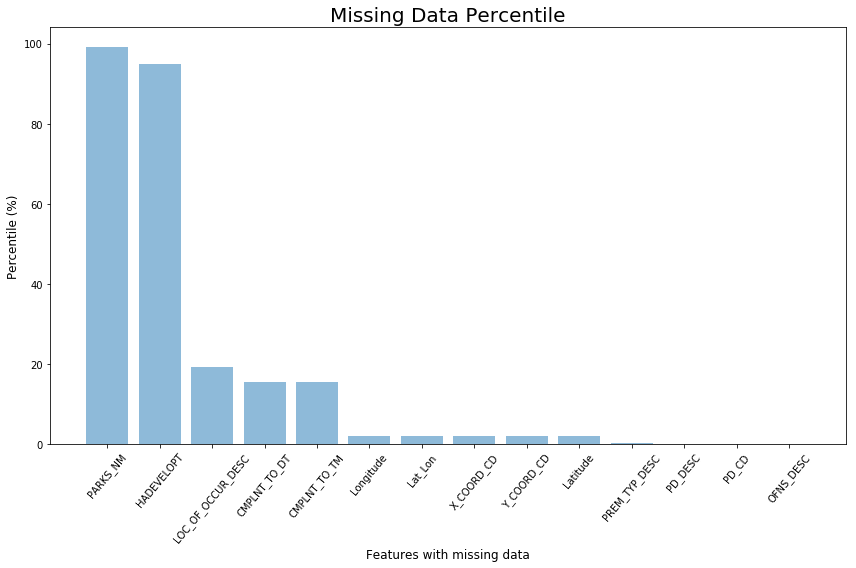

In [133]:
plt.show()

### Cleaning Data

Crime data is cleaned thus having **7 attributes and 458,752 instances**.<br>
Relevant features to our project were selected regarding what we need in modeling and visualization part.

| Field Name | Description |
|:----------:|:---------------------------------------------------|
| Date | Date of occurrence for the reported event |
| Time | Time of occurrence for the reported event |
| Class | Three digit offense classification code |
| Level | Level of offense: felony, misdemeanor, violation |
| Borough | The name of the borough in which the incident occurred |
| Latitude | Latitude coordinate
| Longitude | Longitude coordinate

In [137]:
# Select the columns to be used
df_select = data_crime[['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'KY_CD', "LAW_CAT_CD", "BORO_NM", "Latitude", "Longitude"]]

# Rename the columns
df_select.columns = ['Date', 'Time', 'Class', 'Level', 'Borough', 'Latitude', 'Longitude']

# Erase the rows with missing coordinates
df_crime = df_select[pd.notnull(df_select['Longitude'])]

# Reset index
df_crime = df_crime.reset_index(drop=True)

In [139]:
df_crime.head(5)

,Date,Time,Class,Level,Borough,Latitude,Longitude
0,12/31/2017,12:30:00,344,MISDEMEANOR,BROOKLYN,40.651800,-74.012345
1,12/31/2017,1:00:00,109,FELONY,BRONX,40.821953,-73.928094
2,12/30/2017,15:10:00,105,FELONY,MANHATTAN,40.720892,-73.988818
3,12/30/2017,14:25:00,341,MISDEMEANOR,MANHATTAN,40.750431,-73.989282
4,12/30/2017,14:15:00,348,MISDEMEANOR,QUEENS,40.698443,-73.808546


## 2. AirBnB Data
AirBnB Data contains **16 attributes and 48,852 instances**.

In [46]:
df_airbnb.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2515,Stay at Chez Chic budget room #1,2758,Mizi,Manhattan,Harlem,40.799205,-73.953676,Private room,59,2,164,2018-02-11,1.43,3,316
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.647486,-73.972370,Private room,39,1,7,2017-09-17,0.26,7,365
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.753621,-73.983774,Entire home/apt,225,1,29,2018-01-01,0.29,2,365
3,3330,++ Brooklyn Penthouse Guestroom ++,4177,Julia,Brooklyn,Williamsburg,40.708558,-73.942362,Private room,70,5,27,2017-12-12,0.27,3,279
4,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809018,-73.941902,Private room,150,3,0,NaN,NaN,1,365


In [71]:
missing = df_airbnb.isnull().sum().sort_values(ascending=False)
ratio = (df_airbnb.isnull().sum()/df_airbnb.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing, ratio.round(3)*100], axis=1, keys=["Count", "Percentage"])

# Only show the columns with missing values
missing_data = missing_data[missing_data.Count != 0]

missing_data

,Count,Percentage
reviews_per_month,10936,22.4
last_review,10880,22.3
host_name,106,0.2
name,28,0.1


In [50]:
df_airbnb2 = df_airbnb.drop(['id', 'name', 'host_id', 'neighbourhood_group', 'neighbourhood', 'minimum_nights', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365'], 1)
df_airbnb2.columns = ['Host', 'Latitude', 'Longitude', 'Room_type', 'Price', 'Number_of_reviews']
df_airbnb2

,Host,Latitude,Longitude,Room_type,Price,Number_of_reviews
0,Mizi,40.799205,-73.953676,Private room,59,164
1,John,40.647486,-73.972370,Private room,39,7
2,Jennifer,40.753621,-73.983774,Entire home/apt,225,29
3,Julia,40.708558,-73.942362,Private room,70,27
4,Elisabeth,40.809018,-73.941902,Private room,150,0
5,LisaRoxanne,40.685138,-73.959757,Entire home/apt,89,181
6,New-Yorker,40.762600,-73.993045,Entire home/apt,150,26
7,Tom,40.765509,-73.986313,Entire home/apt,150,58
8,Garon,40.686882,-73.955957,Private room,60,51
9,Rebecca,40.661197,-73.994227,Entire home/apt,253,1


# Clustering

Clustering is done on unlabelled data returning a label for each datapoint. Classification requires labels.

Therefore you first cluster your data and save the resulting cluster labels. Then you train a classifier using these labels as a target variable. By saving the labels you effectively seperate the steps of clustering and classification. This enables you to use any classification algorithm (Random Forest, SVM, Naive Bayes, etc)

The problematic part of this pipeline is the lack of robustness of the k-means algorithm. Therefore we will have to evaluate the clustering result and possibly repetitivly perform k-means.

[Reference from Stackoverflow: How to do classification after clustering](https://stats.stackexchange.com/questions/264312/how-to-do-classification-after-clustering)


In [17]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X = df_crime[['Longitude', 'Latitude']].values

kmns = KMeans(n_clusters=50, init='k-means++', precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')
kY = kmns.fit_predict(X)

### Clusters using crime data<br>

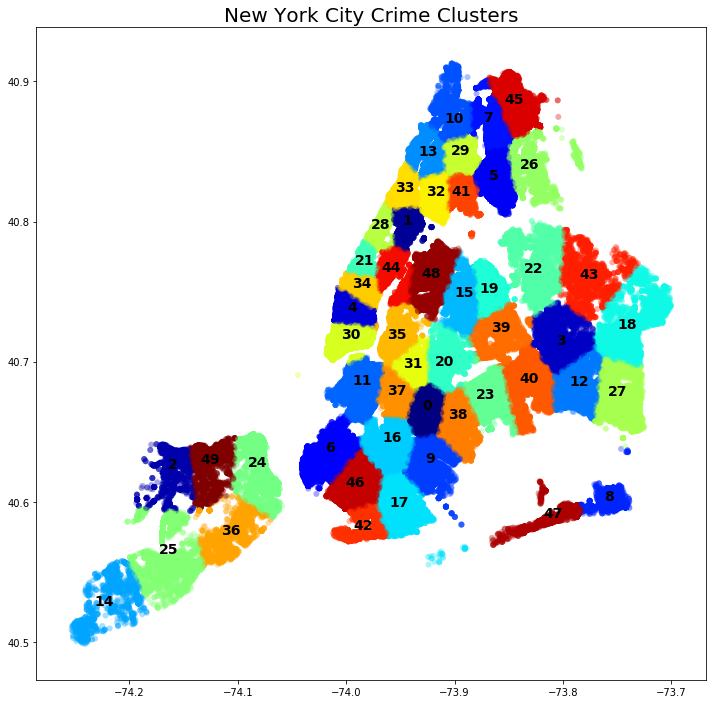

In [382]:
fig=plt.figure(figsize=(12, 12))

plt.scatter(X[:,0], X[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.35)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=14, horizontalalignment='center', weight='bold')

plt.title('New York City Crime Clusters', size=20)

# 50 Clusters
plt.show()

### Clusters with google map<br>


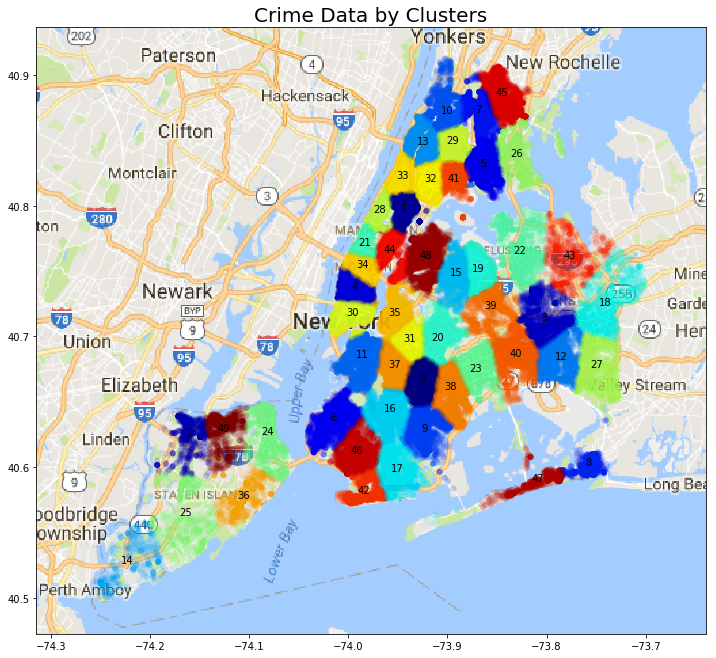

In [383]:
from PIL import Image
import requests
from io import BytesIO

fig=plt.figure(figsize=(12, 12))

url = "http://maps.googleapis.com/maps/api/staticmap?center=40.705745465,-73.97695376499999&size=800x800&zoom=10&sensor=false"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img, zorder=0, extent=[-74.414690, -73.539312, 40.372528, 41.036494], aspect=1.31841)

plt.scatter(X[:,0], X[:,1],  c=kY, cmap = "jet", edgecolor = "None", alpha=0.05)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=10, horizontalalignment='center')

plt.title('Crime Data by Clusters', size=20)

(xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()

axes = plt.gca()
axes.set_xlim([xmin+0.1,xmax-0.1])
axes.set_ylim([ymin+0.1,ymax-0.1])

plt.show()

In [52]:
df_crime_safety = pd.DataFrame(np.array(np.hstack((X, np.array([kY]).T)), dtype=int), columns=['Latitude', 'Longitude', 'Cluster'])
df_cluster_crime = df_crime_safety.groupby(['Cluster']).agg('size').reset_index(name='Crime').set_index('Cluster')
df_cluster_crime

,Crime
Cluster,
0,11180
1,13913
2,2667
3,6992
4,11908
5,9962
6,8106
7,7677
8,2969


In [54]:
c_min, c_max = df_cluster_crime.values.min(), df_cluster_crime.values.max()+1
crime_range = np.linspace(c_min, c_max, 6)

pd.DataFrame(crime_range)

,0
0,1385.0
1,3890.8
2,6396.6
3,8902.4
4,11408.2
5,13914.0


In [55]:
cluster_dict = dict(zip(df_cluster_crime.index.values, df_cluster_crime['Crime'].values))

sorted_x = dict(sorted(cluster_dict.items(), key=lambda x: x[1]))
sorted_x

{0: 11180,
 1: 13913,
 2: 2667,
 3: 6992,
 4: 11908,
 5: 9962,
 6: 8106,
 7: 7677,
 8: 2969,
 9: 5162,
 10: 10277,
 11: 11366,
 12: 5725,
 13: 13800,
 14: 1385,
 15: 5572,
 16: 10324,
 17: 5334,
 18: 3963,
 19: 7373,
 20: 8306,
 21: 6447,
 22: 6112,
 23: 7977,
 24: 5049,
 25: 2459,
 26: 4218,
 27: 3988,
 28: 5558,
 29: 11668,
 30: 13162,
 31: 8643,
 32: 13744,
 33: 11591,
 34: 13431,
 35: 6322,
 36: 2137,
 37: 8555,
 38: 10951,
 39: 3688,
 40: 6175,
 41: 8854,
 42: 4442,
 43: 2374,
 44: 6967,
 45: 7193,
 46: 5039,
 47: 2626,
 48: 7333,
 49: 2961}

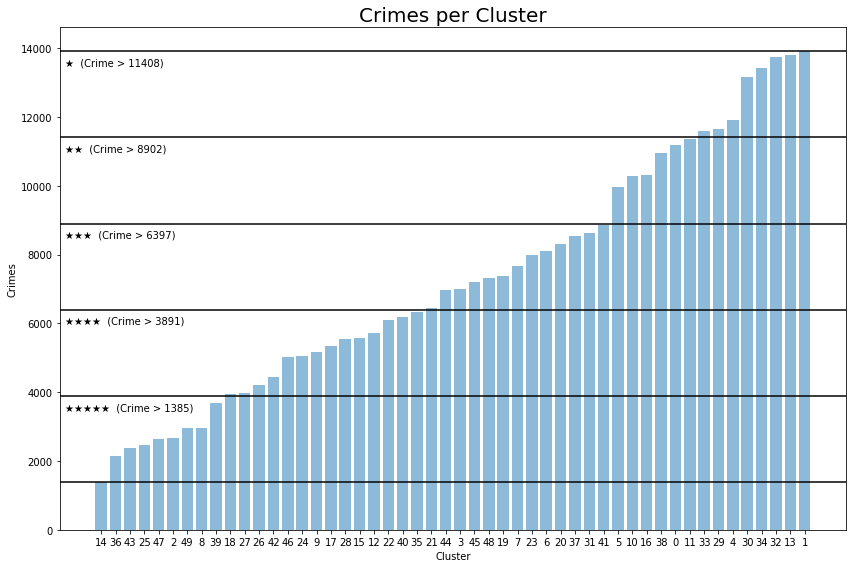

In [388]:
fig=plt.figure(figsize=(12, 8))

objects = sorted_x.keys()
y_pos = np.arange(len(objects))
performance = sorted_x.values()
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Crimes')
plt.xlabel('Cluster')
plt.title('Crimes per Cluster', size=20)

for i, border in enumerate(crime_range):
    plt.axhline(y=border, c='black', hold=None)
    if i<5:
        plt.text(-2.5, border+(c_max-c_min)/6, "★"*(5-i)+'  (Crime > %.0f)' % border, size=10)
    
plt.tight_layout()
plt.show()

In [74]:
df_cluster_crime['Safety'] = 6 - ((df_cluster_crime['Crime'] - c_min) // ((c_max-c_min)/5) + 1)
df_cluster_crime

,Crime,Safety
Cluster,,
0,11180,2.0
1,13913,1.0
2,2667,5.0
3,6992,3.0
4,11908,1.0
5,9962,2.0
6,8106,3.0
7,7677,3.0
8,2969,5.0


In [108]:
safeY = []
for x in kY:
    safeY.append(df_cluster_crime['Safety'][x])

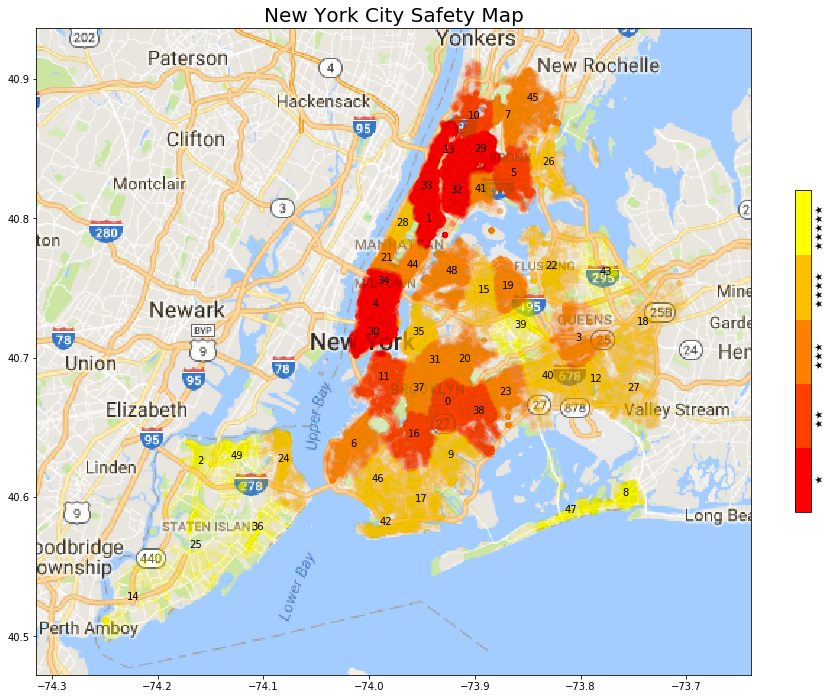

In [379]:
from PIL import Image
import requests
from io import BytesIO

fig=plt.figure(figsize=(16, 16))

url = "http://maps.googleapis.com/maps/api/staticmap?center=40.705745465,-73.97695376499999&size=800x800&zoom=10&sensor=false"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img, zorder=0, extent=[-74.414690, -73.539312, 40.372528, 41.036494], aspect=1.31841)

plt.scatter(X[:,0], X[:,1],  c=safeY, cmap = plt.cm.get_cmap('autumn',5), edgecolor = "None", alpha=0.02)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=10, horizontalalignment='center')

color_bar = plt.colorbar(ticks=[], label='     ★               ★★             ★★★           ★★★★       ★★★★★', shrink=0.37)
color_bar.set_alpha(50)
color_bar.draw_all()
plt.title('New York City Safety Map', size=20)

(xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()

axes = plt.gca()
axes.set_xlim([xmin+0.1,xmax-0.1])
axes.set_ylim([ymin+0.1,ymax-0.1])

plt.show()

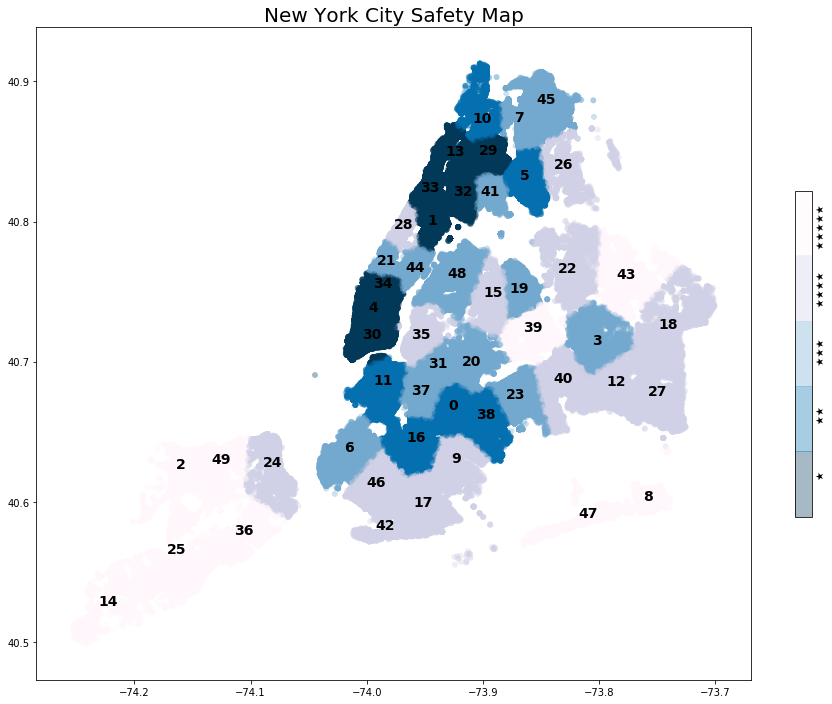

In [110]:
fig=plt.figure(figsize=(16, 12))
plt.scatter(X[:,0], X[:,1],  c=safeY, cmap = plt.cm.get_cmap('PuBu_r',5), edgecolor = "None", alpha=0.35)
for i in range(len(kmns.cluster_centers_)):
    plt.text(kmns.cluster_centers_[i,0],kmns.cluster_centers_[i,1], i, size=14, horizontalalignment='center', weight='bold')

plt.colorbar(ticks=[], label='        ★               ★★             ★★★          ★★★★       ★★★★★', shrink=0.5)
plt.title('New York City Safety Map', size=20)
plt.show()

In [ ]:
'''
Modeling - Classification

1. K-nearest neighbour
2. Density Estimation

'''

In [112]:
# Add safety as a target feature

column = list(df_crime2.columns)
column.append('Safety')

df_crime_added_safety = pd.DataFrame(np.concatenate((df_crime2, np.array([safeY]).T), axis=1), columns=column)
df_crime_added_safety

,Date,Time,Classification_Num,Crime_Cat,Cat_Num,Neighborhood_Group,Latitude,Longitude,Safety
0,1/1/2017,0:00:00,233,MISDEMEANOR,2,BRONX,40.5873,-73.9315,4
1,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.6984,-73.932,3
2,1/1/2017,0:00:00,233,MISDEMEANOR,2,BRONX,40.5823,-74.1689,5
3,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.7025,-73.9346,3
4,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.7271,-73.9527,4
5,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.7271,-73.9527,4
6,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.6201,-73.9987,4
7,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.6201,-73.9987,4
8,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.6179,-73.9993,4
9,1/1/2017,0:00:00,351,MISDEMEANOR,2,BROOKLYN,40.6988,-73.9384,3


In [135]:
df_crime_added_safety.groupby(["Neighborhood_Group","Crime_Cat"]).agg({'Safety':'count'}).rename(columns={'Safety':'Count'})

count
Neighborhood_Group Crime_Cat         
BRONX              FELONY       22158
                   MISDEMEANOR  46588
                   VIOLATION    11978
BROOKLYN           FELONY       33889
                   MISDEMEANOR  57513
                   VIOLATION    15675
MANHATTAN          FELONY       26494
                   MISDEMEANOR  51130
                   VIOLATION    10372
QUEENS             FELONY       22392
                   MISDEMEANOR  37486
                   VIOLATION    11295
STATEN ISLAND      FELONY        3634
                   MISDEMEANOR   9288
                   VIOLATION     3733

In [113]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split

data = df_crime_added_safety

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(data[['Latitude', 'Longitude']], data['Safety'].astype('int'), test_size=0.2, random_state=0)

knn = KNeighborsClassifier(algorithm='kd_tree')

param_grid = {'n_neighbors': list(range(8, 13)), 'weights': ['uniform', 'distance']}

rand_clf = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
rand_clf.fit(X_train, y_train)

test_score = rand_clf.score(X_test, y_test)
print('cross-validated test score: {:.4f}(%)'.format(test_score*100))

cross-validated test score: 99.9257(%)


In [ ]:
# Density Estimation
'''
from sklearn.neighbors.kde import KernelDensity

kde = KernelDensity(kernel='gaussian')
kde.fit(X_train, y_train)

# kde.score_samples(X)

test_score = kde.score(X_test, y_test)
print('test score: {:.4f}(%)'.format(test_score*100))
'''

In [ ]:
from sklearn.ensemble import RandomForestClassifier
X, y = make_classification(n_samples=1000, n_features=4,
...                            n_informative=2, n_redundant=0,
...                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)


In [ ]:
'''
Airbnb Safety Calculation
'''

In [71]:
kY_airbnb = rand_clf.predict(X_airbnb)

column = list(df_airbnb.columns)
column.append('Safety')

df_airbnb_safety = pd.DataFrame(np.concatenate((df_airbnb, np.array([kY_airbnb]).T), axis=1), columns=column)
df_airbnb_safety

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Safety
0,2515,Stay at Chez Chic budget room #1,2758,Mizi,Manhattan,Harlem,40.7992,-73.9537,Private room,59,2,164,2018-02-11,1.43,3,316,5
1,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.6475,-73.9724,Private room,39,1,7,2017-09-17,0.26,7,365,4
2,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.7536,-73.9838,Entire home/apt,225,1,29,2018-01-01,0.29,2,365,5
3,3330,++ Brooklyn Penthouse Guestroom ++,4177,Julia,Brooklyn,Williamsburg,40.7086,-73.9424,Private room,70,5,27,2017-12-12,0.27,3,279,2
4,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.809,-73.9419,Private room,150,3,0,NaN,NaN,1,365,5
5,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.6851,-73.9598,Entire home/apt,89,1,181,2018-02-24,4.34,1,126,3
6,4989,Available! Perfect location! Entire apartment!,7118,New-Yorker,Manhattan,Hell's Kitchen,40.7626,-73.993,Entire home/apt,150,1,26,2018-01-01,0.26,1,17,5
7,5054,Midtown West,7231,Tom,Manhattan,Hell's Kitchen,40.7655,-73.9863,Entire home/apt,150,1,58,2016-12-23,0.53,1,2,3
8,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.6869,-73.956,Private room,60,45,51,2017-10-05,0.48,2,365,3
9,5136,Spacious Brooklyn Duplex + Garden,7378,Rebecca,Brooklyn,Sunset Park,40.6612,-73.9942,Entire home/apt,253,4,1,2014-01-02,0.02,1,358,4


In [73]:
df_airbnb_safety.to_csv("airbnb_safety.csv", encoding='utf-8')

In [182]:
list(df_crime2[['Latitude', 'Longitude']].values)

[array([ 40.58726411, -73.9315477 ]),
 array([ 40.69839253, -73.93201063]),
 array([ 40.58230199, -74.1689361 ]),
 array([ 40.70250298, -73.93464646]),
 array([ 40.72710762, -73.95268719]),
 array([ 40.72710762, -73.95268719]),
 array([ 40.62012049, -73.99870467]),
 array([ 40.62012049, -73.99870467]),
 array([ 40.61791094, -73.99934948]),
 array([ 40.69875294, -73.93837553]),
 array([ 40.81770983, -73.92397301]),
 array([ 40.67825086, -73.95289129]),
 array([ 40.69479375, -73.93134355]),
 array([ 40.69409858, -73.93010736]),
 array([ 40.59948742, -73.98977453]),
 array([ 40.5799555 , -73.97322126]),
 array([ 40.70178911, -73.91349834]),
 array([ 40.66778741, -73.9005871 ]),
 array([ 40.85097105, -73.85578817]),
 array([ 40.70818174, -73.92123406]),
 array([ 40.60491707, -73.99794149]),
 array([ 40.60491707, -73.99794149]),
 array([ 40.60491707, -73.99794149]),
 array([ 40.60491707, -73.99794149]),
 array([ 40.60491707, -73.99794149]),
 array([ 40.60491707, -73.99794149]),
 array([ 40.

In [392]:
from gmplot import gmplot

# Place map
gmap = gmplot.GoogleMapPlotter(40.75, -73.97, 11)

lats, lons = df_crime2[['Latitude']].values, df_crime2[['Longitude']].values
for lat,lon in zip(lats,lons):
    gmap.marker(lat, lon, 'cornflowerblue')

# Draw
gmap.draw("airbnb.html")

from IPython.display import HTML
HTML("airbnb.html")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


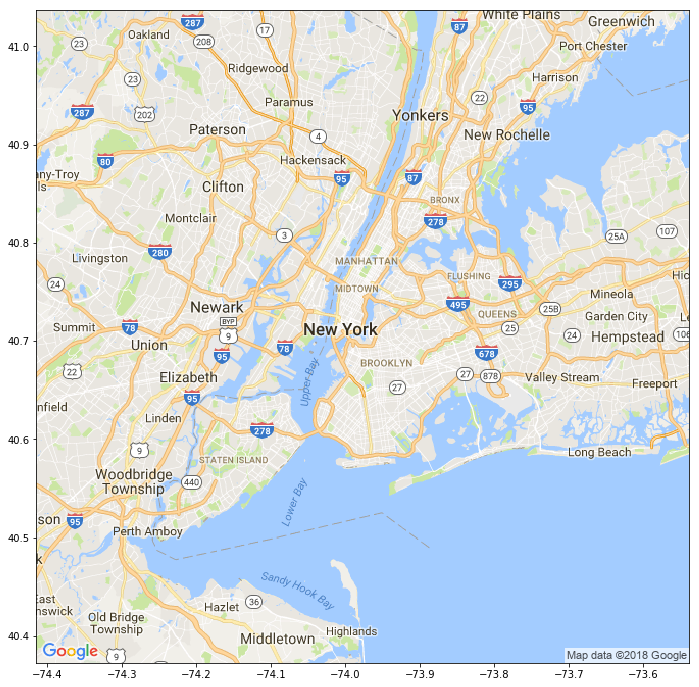

In [363]:
fig=plt.figure(figsize=(12,12))

url = "http://maps.googleapis.com/maps/api/staticmap?center=40.705745465,-73.97695376499999&size=800x800&zoom=10&sensor=false"
response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img, zorder=0, extent=[-74.414690, -73.539312, 40.372528, 41.036494], aspect=1.31841)
plt.show()